In [1]:
import random
from tqdm.autonotebook import tqdm

In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn import metrics as skmetrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, quantile_transform, QuantileTransformer
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
import logging

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
df = pd.read_parquet("./dataset.parquet")\
    .dropna(subset=['month_purchase'])

df.loc[:, 'not_same_day'] = (
    (df.loc[:, 'has_second_sale_within_year'] == 1) & 
    (df.loc[:, 'waiting_time'] > 0)
)

df = df.loc[df.not_same_day == 1]

categorical_columns = ['partner', 'device', 'gender', 'state', 'channel']
feature_columns = [
    'channel', 'partner', 'device', 'age', 'gender', 'state', 'has_marketplace', 
    'has_crossdocking', 'has_private_label', 'has_brands', 'gmv', 'fst_sale_in_black_friday_days'
]

In [5]:
df.loc[:, 'period'] = quantile_transform(df.loc[:, ['waiting_time']])

In [6]:
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [7]:
features = [c for c in df.columns if any([c.startswith(x) for x in feature_columns])]
X = df.loc[:, features]
y = df.loc[:, 'period']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [9]:
qt = QuantileTransformer()
qt.fit(X_train.loc[:, ["age", "gmv"]])

X_train.loc[:, ["age", "gmv"]] = qt.transform(X_train.loc[:, ["age", "gmv"]])
X_test.loc[:, ["age", "gmv"]] = qt.transform(X_test.loc[:, ["age", "gmv"]])

/home/calsaverini/.local/share/virtualenvs/survival-Ls_z5C1J/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/calsaverini/.local/share/virtualenvs/survival-Ls_z5C1J/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [10]:
HYPERPARAMETER_SPACE = [
    Integer(1, 10, name='min_child_weight'),
    Real(1e-5, 1.0, "uniform", name='learning_rate'),
    Real(0.1, 10, "log-uniform", name='gamma'),    
    Real(0.05, 1, name='subsample'),
    Real(0.05, 1, name='colsample_bytree'),
    Integer(2, 10, name='max_depth'),
    Integer(2, 200, name="n_estimators"),
    Real(0.01, 0.99, name="base_score"),
    Real(0, 5, name="scale_pos_weight"),
    Real(0, 5, name="reg_alpha"),
    Real(0, 5, name="reg_lambda"),
]

HYPERPARAMETER_NAMES = [dim.name for dim in HYPERPARAMETER_SPACE]

In [11]:
RANDOM_STATE = 939568576
TREE_METHOD = 'hist'#'exact'
NUM_PROCESSORS = 8
NUM_CROSS_VALIDATION_STEPS = 11
NUM_GP_OPTIMIZATION_STEPS = 100

In [12]:
def get_logger(name):
    logger = logging.getLogger(name)
    formatter = logging.Formatter('[%(levelname)s] %(asctime)s: %(name)s - %(message)s')
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)
    logger.setLevel(logging.INFO)
    return logger

In [13]:
def train_model(X, y, **kwargs):
    model = XGBRegressor(
        random_state=RANDOM_STATE,
        tree_method=TREE_METHOD,
        n_jobs=NUM_PROCESSORS,
        **kwargs,
    )
    model.fit(X, y)
    return model

def evaluate_model(X, y, **kwargs):
    roc_auc = []
    for _ in range(NUM_CROSS_VALIDATION_STEPS):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5000)
        model = train_model(X_train.values, y_train.values, **kwargs)
        y_pred = model.predict(X_test.values)
        roc_auc.append(skmetrics.r2_score(y_test.values, y_pred))
    return np.mean(roc_auc)


def train_optimized_model(X, y):
    
    logger = get_logger(__name__)
    
    @use_named_args(HYPERPARAMETER_SPACE)
    def loss(**kwargs):
        return -evaluate_model(X, y, **kwargs)

    def get_optimization_callback():
        def callback(res):          
            current_value = -res.func_vals[-1]
            best_value = -res.func_vals.min()            
            current_params = pd.Series(dict(zip(
                HYPERPARAMETER_NAMES, 
                map(fix_type, res.x)
            )))
            logger.info(
                f"Optimization iteration "
                f"{len(res.func_vals):d}/{NUM_GP_OPTIMIZATION_STEPS:d}. "
                f"Current: {current_value:5.3f}. Best: {best_value:5.3f}. "
#                 f"Parameters:\n{current_params}"
            )

        return callback

    def fix_type(x):
        if isinstance(x, bool):
            return x
        elif np.issubdtype(np.dtype(x), np.int_):
            return int(x)
        elif np.issubdtype(np.dtype(x), np.float_):
            return float(x)

    logger.info("Will start hyperparameter optimization.")
    optimization_results = gp_minimize(
        loss,
        HYPERPARAMETER_SPACE,
        n_random_starts=max(1, min(10, int(NUM_GP_OPTIMIZATION_STEPS / 2))),
        n_calls=NUM_GP_OPTIMIZATION_STEPS,
        random_state=RANDOM_STATE,
        callback=get_optimization_callback(),
    )
    logger.info("Finished hyperparameter optimization.")
    best_parameters = dict(
        zip(HYPERPARAMETER_NAMES, map(fix_type, optimization_results.x))
    )
    logger.info("Starting training of final model.")
    return train_model(X, y, verbosity=1, **best_parameters)


In [14]:
%time best_model = train_optimized_model(X_train, y_train)

[INFO] 2019-04-18 17:14:39,839: __main__ - Will start hyperparameter optimization.
[INFO] 2019-04-18 17:15:56,912: __main__ - Optimization iteration 1/100. Current: 0.053. Best: 0.053. 
[INFO] 2019-04-18 17:18:34,351: __main__ - Optimization iteration 2/100. Current: 0.053. Best: 0.053. 
[INFO] 2019-04-18 17:18:58,541: __main__ - Optimization iteration 3/100. Current: 0.047. Best: 0.053. 
[INFO] 2019-04-18 17:19:09,641: __main__ - Optimization iteration 4/100. Current: 0.039. Best: 0.053. 
[INFO] 2019-04-18 17:20:37,759: __main__ - Optimization iteration 5/100. Current: 0.046. Best: 0.053. 
[INFO] 2019-04-18 17:21:16,057: __main__ - Optimization iteration 6/100. Current: 0.049. Best: 0.053. 
[INFO] 2019-04-18 17:21:56,626: __main__ - Optimization iteration 7/100. Current: 0.045. Best: 0.053. 
[INFO] 2019-04-18 17:26:57,208: __main__ - Optimization iteration 8/100. Current: 0.033. Best: 0.053. 
[INFO] 2019-04-18 17:28:17,147: __main__ - Optimization iteration 9/100. Current: 0.049. Best

[INFO] 2019-04-18 19:26:31,119: __main__ - Optimization iteration 79/100. Current: 0.043. Best: 0.057. 
[INFO] 2019-04-18 19:26:45,258: __main__ - Optimization iteration 80/100. Current: 0.036. Best: 0.057. 
[INFO] 2019-04-18 19:27:45,256: __main__ - Optimization iteration 81/100. Current: 0.050. Best: 0.057. 
[INFO] 2019-04-18 19:28:46,402: __main__ - Optimization iteration 82/100. Current: 0.050. Best: 0.057. 
[INFO] 2019-04-18 19:29:23,630: __main__ - Optimization iteration 83/100. Current: 0.052. Best: 0.057. 
[INFO] 2019-04-18 19:30:55,359: __main__ - Optimization iteration 84/100. Current: 0.044. Best: 0.057. 
[INFO] 2019-04-18 19:36:53,120: __main__ - Optimization iteration 85/100. Current: 0.050. Best: 0.057. 
[INFO] 2019-04-18 19:37:30,947: __main__ - Optimization iteration 86/100. Current: 0.048. Best: 0.057. 
[INFO] 2019-04-18 19:38:33,194: __main__ - Optimization iteration 87/100. Current: 0.054. Best: 0.057. 
[INFO] 2019-04-18 19:42:12,389: __main__ - Optimization iteratio

CPU times: user 17h 18min 27s, sys: 20min 34s, total: 17h 39min 1s
Wall time: 2h 40min 18s


In [15]:
y_pred = best_model.predict(X_test)
print(skmetrics.r2_score(y_test, y_pred))
print(skmetrics.explained_variance_score(y_test, y_pred))

0.050990342004293865
0.050993994124539754


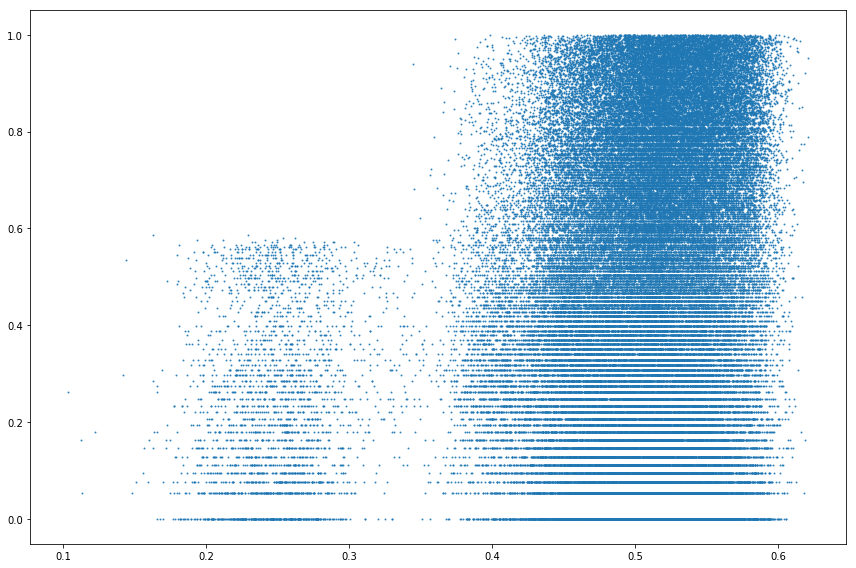

In [16]:
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(111)
ax.set_title(f"")
ax.scatter(y_pred, y_test, s=1, alpha=0.8)

fig.tight_layout()

In [17]:
import shap
shap.initjs()

In [18]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

In [19]:
shap.force_plot(
    explainer.expected_value,
    shap_values[0, :],
    X_test.iloc[0, :]
)

In [20]:
sample = X_test.sample(1000).index

In [21]:
shap_values_df = pd.DataFrame(shap_values, columns=X_test.columns, index=X_test.index)

In [22]:
shap.force_plot(
    explainer.expected_value, 
    shap_values_df.loc[sample, :].values, 
    X_test.loc[sample, :],
    link="logit"
)